<a href="https://colab.research.google.com/github/taaazz/Application_Mobile_Project/blob/main/Emotion_Detection_with_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from keras.preprocessing.text import Tokenizer
from keras.optimizers import Adamax
from keras.metrics import Precision, Recall
from keras.layers import Dense, ReLU
from keras.layers import Embedding, BatchNormalization, Concatenate
from keras.layers import Conv1D, GlobalMaxPooling1D, Dropout
from keras.models import Sequential, Model
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/dataset/Emotion_detection/train.txt",
                 delimiter=';', header=None, names=['sentence','label'])

val_df = pd.read_csv("/content/drive/MyDrive/dataset/Emotion_detection/val.txt",
                 delimiter=';', header=None, names=['sentence','label'])

ts_df = pd.read_csv("/content/drive/MyDrive/dataset/Emotion_detection/test.txt",
                 delimiter=';', header=None, names=['sentence','label'])

In [ ]:
df

,sentence,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


In [ ]:
df['label'].unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

In [ ]:
df.label.value_counts()

joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: label, dtype: int64

In [ ]:
df = df[~df['label'].str.contains('love')]
df = df[~df['label'].str.contains('surprise')]

In [ ]:
joy = df[df['label'] == 'joy'].sample(n=2200, random_state=20)
sad = df[df['label'] == 'sadness'].sample(n=2200, random_state=20)
fear = df[df['label'] == 'fear'].sample(n=1937, random_state=20)
anger = df[df['label'] == 'anger'].sample(n=2159, random_state=20)

df_sampled = pd.concat([joy, sad, fear, anger])

df = df_sampled.sample(frac=1, random_state=20).reset_index(drop=True)

In [ ]:
df.label.value_counts()

joy        2200
sadness    2200
anger      2159
fear       1937
Name: label, dtype: int64

In [ ]:
val_df.label.value_counts()

joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: label, dtype: int64

In [ ]:
val_df = val_df[~val_df['label'].str.contains('love')]
val_df = val_df[~val_df['label'].str.contains('surprise')]

In [ ]:
joy = val_df[val_df['label'] == 'joy'].sample(n=250, random_state=20)
sad = val_df[val_df['label'] == 'sadness'].sample(n=250, random_state=20)
fear = val_df[val_df['label'] == 'fear'].sample(n=212, random_state=20)
anger = val_df[val_df['label'] == 'anger'].sample(n=275, random_state=20)

df_sampled = pd.concat([joy, sad, fear, anger])

val_df = df_sampled.sample(frac=1, random_state=20).reset_index(drop=True)

In [ ]:
ts_df.label.value_counts()

joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: label, dtype: int64

In [ ]:
ts_df = ts_df[~ts_df['label'].str.contains('love')]
ts_df = ts_df[~ts_df['label'].str.contains('surprise')]

In [ ]:
joy = ts_df[ts_df['label'] == 'joy'].sample(n=250, random_state=20)
sad = ts_df[ts_df['label'] == 'sadness'].sample(n=250, random_state=20)
fear = ts_df[ts_df['label'] == 'fear'].sample(n=224, random_state=20)
anger = ts_df[ts_df['label'] == 'anger'].sample(n=275, random_state=20)

df_sampled = pd.concat([joy, sad, fear, anger])

ts_df = df_sampled.sample(frac=1, random_state=20).reset_index(drop=True)

Split Data into X,Y

In [ ]:
tr_text = df['sentence']
tr_label = df['label']

val_text = val_df['sentence']
val_label = val_df['label']

ts_text = ts_df['sentence']
ts_label = ts_df['label']

In [ ]:
encoder = LabelEncoder()
tr_label = encoder.fit_transform(tr_label)
val_label = encoder.transform(val_label)
ts_label = encoder.transform(ts_label)

Teks Pre-Processing

In [ ]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(tr_text)

sequences = tokenizer.texts_to_sequences(tr_text)

tr_x = pad_sequences(sequences, maxlen=50)
tr_y = to_categorical(tr_label)

sequences = tokenizer.texts_to_sequences(val_text)
val_x = pad_sequences(sequences, maxlen=50)
val_y = to_categorical(val_label)

sequences = tokenizer.texts_to_sequences(ts_text)
ts_x = pad_sequences(sequences, maxlen=50)
ts_y = to_categorical(ts_label)

building Deep Learning Model

In [ ]:
max_words = 10000
max_len = 50
embedding_dim = 32

In [ ]:
# Branch 1
branch1 = Sequential()
branch1.add(Embedding(max_words, embedding_dim, input_length=max_len))
branch1.add(Conv1D(64, 3, padding='same', activation='relu'))
branch1.add(BatchNormalization())
branch1.add(ReLU())
branch1.add(Dropout(0.5))
branch1.add(GlobalMaxPooling1D())

# Branch 2
branch2 = Sequential()
branch2.add(Embedding(max_words, embedding_dim, input_length=max_len))
branch2.add(Conv1D(64, 3, padding='same', activation='relu'))
branch2.add(BatchNormalization())
branch2.add(ReLU())
branch2.add(Dropout(0.5))
branch2.add(GlobalMaxPooling1D())

concatenated = Concatenate()([branch1.output, branch2.output])

hid_layer = Dense(128, activation='relu')(concatenated)
dropout = Dropout(0.3)(hid_layer)
output_layer = Dense(4, activation='softmax')(dropout)

model = Model(inputs=[branch1.input, branch2.input], outputs=output_layer)

In [ ]:
model.compile(optimizer='adamax',
              loss='categorical_crossentropy',
              metrics=['accuracy', Precision(), Recall()])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 embedding_input (InputLaye  [(None, 50)]                 0         []                            
 r)                                                                                               
                                                                                                  
 embedding_1_input (InputLa  [(None, 50)]                 0         []                            
 yer)                                                                                             
                                                                                                  
 embedding (Embedding)       (None, 50, 32)               320000    ['embedding_input[0][0]']     
                                                                                              

Training Model

In [ ]:
batch_size = 256
epochs = 25
history = model.fit([tr_x, tr_x], tr_y, epochs=epochs, batch_size=batch_size,
                    validation_data=([val_x, val_x], val_y))

Epoch 1/25
34/34 [==============================] - 6s 107ms/step - loss: 1.7129 - accuracy: 0.2710 - precision: 0.2715 - recall: 0.1185 - val_loss: 1.3848 - val_accuracy: 0.3040 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/25
34/34 [==============================] - 3s 84ms/step - loss: 1.3929 - accuracy: 0.3216 - precision: 0.3878 - recall: 0.0537 - val_loss: 1.3849 - val_accuracy: 0.3181 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/25
34/34 [==============================] - 4s 130ms/step - loss: 1.3267 - accuracy: 0.3625 - precision: 0.5170 - recall: 0.0412 - val_loss: 1.3842 - val_accuracy: 0.3404 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/25
34/34 [==============================] - 3s 86ms/step - loss: 1.2665 - accuracy: 0.4122 - precision: 0.6280 - recall: 0.0727 - val_loss: 1.3810 - val_accuracy: 0.4063 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/25
34/34 [==============================] - 3s 81ms/step - loss: 1

In [ ]:
(loss, accuracy, percision, recall) = model.evaluate([tr_x, tr_x], tr_y)
print(f'Loss: {round(loss, 2)}, Accuracy: {round(accuracy, 2)}, Precision: {round(percision, 2)}, Recall: {round(recall, 2)}')

266/266 [==============================] - 2s 8ms/step - loss: 0.0454 - accuracy: 0.9940 - precision: 0.9945 - recall: 0.9931
Loss: 0.05, Accuracy: 0.99, Precision: 0.99, Recall: 0.99


In [ ]:
(loss, accuracy, percision, recall) = model.evaluate([ts_x, ts_x], ts_y)
print(f'Loss: {round(loss, 2)}, Accuracy: {round(accuracy, 2)}, Precision: {round(percision, 2)}, Recall: {round(recall, 2)}')

32/32 [==============================] - 0s 8ms/step - loss: 0.1851 - accuracy: 0.9399 - precision: 0.9516 - recall: 0.9259
Loss: 0.19, Accuracy: 0.94, Precision: 0.95, Recall: 0.93


In [ ]:
y_true=[]
for i in range(len(ts_y)):

    x = np.argmax(ts_y[i])
    y_true.append(x)

In [ ]:
preds = model.predict([ts_x, ts_x])
y_pred = np.argmax(preds, axis=1)
y_pred

32/32 [==============================] - 0s 5ms/step


array([0, 1, 0, 2, 0, 3, 1, 2, 0, 3, 0, 0, 1, 1, 3, 1, 2, 2, 3, 2, 1, 0,
       2, 0, 3, 3, 1, 3, 2, 0, 2, 3, 1, 1, 0, 0, 2, 0, 3, 1, 3, 2, 1, 0,
       0, 2, 0, 3, 1, 3, 0, 3, 0, 2, 2, 2, 1, 1, 3, 2, 0, 1, 3, 3, 1, 2,
       0, 3, 0, 3, 1, 0, 1, 1, 1, 3, 1, 3, 0, 2, 2, 0, 1, 3, 0, 3, 0, 0,
       2, 2, 0, 2, 3, 1, 2, 2, 2, 3, 3, 1, 2, 2, 3, 1, 1, 2, 3, 0, 2, 1,
       1, 2, 0, 0, 3, 1, 3, 3, 0, 2, 2, 1, 3, 0, 1, 0, 1, 0, 0, 1, 2, 1,
       0, 1, 2, 2, 3, 3, 3, 1, 0, 3, 3, 1, 3, 0, 0, 0, 0, 2, 3, 1, 3, 3,
       3, 2, 3, 3, 0, 3, 1, 3, 0, 2, 0, 0, 1, 1, 1, 0, 2, 3, 1, 3, 2, 3,
       2, 2, 1, 2, 0, 0, 2, 0, 2, 0, 3, 3, 2, 2, 2, 1, 1, 3, 2, 2, 3, 1,
       1, 0, 1, 1, 2, 0, 2, 0, 2, 2, 0, 3, 3, 1, 3, 2, 0, 1, 2, 1, 2, 3,
       0, 2, 1, 2, 1, 0, 3, 3, 1, 3, 1, 0, 3, 1, 3, 1, 0, 0, 3, 3, 3, 2,
       0, 3, 1, 3, 2, 0, 1, 2, 0, 0, 3, 1, 1, 2, 1, 3, 0, 3, 0, 0, 2, 2,
       0, 0, 2, 0, 2, 1, 2, 0, 2, 2, 1, 2, 3, 2, 2, 0, 1, 3, 3, 1, 3, 0,
       2, 1, 1, 0, 1, 1, 3, 3, 2, 1, 1, 3, 0, 2, 2,

              precision    recall  f1-score   support

           0       0.92      0.93      0.92       275
           1       0.93      0.95      0.94       224
           2       0.95      0.97      0.96       250
           3       0.97      0.91      0.94       250

    accuracy                           0.94       999
   macro avg       0.94      0.94      0.94       999
weighted avg       0.94      0.94      0.94       999



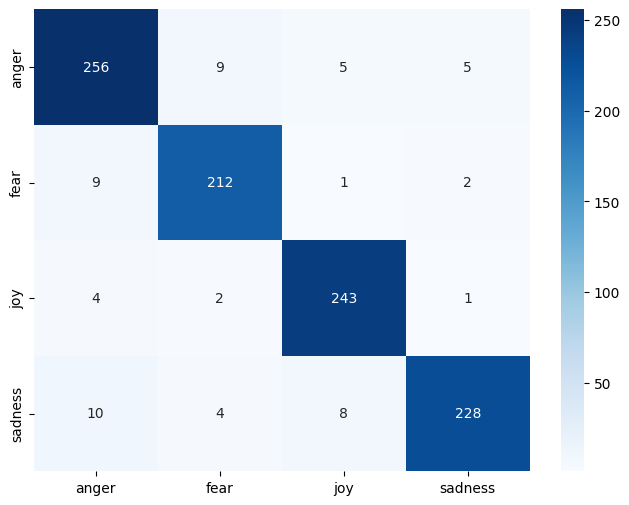

In [ ]:
plt.figure(figsize=(8,6))
emotions = {0: 'anger', 1: 'fear', 2: 'joy', 3:'sadness'}
emotions = list(emotions.values())
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotions, yticklabels=emotions)

clr = classification_report(y_true, y_pred)
print(clr)

Prediction Function

In [ ]:
def predict(text, model_path, token_path):
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    import matplotlib.pyplot as plt
    import pickle
    from tensorflow.keras.models import load_model

    model = load_model(model_path)


    with open(token_path, 'rb') as f:
        tokenizer = pickle.load(f)

    sequences = tokenizer.texts_to_sequences([text])
    x_new = pad_sequences(sequences, maxlen=50)
    predictions = model.predict([x_new, x_new])

    emotions = {0: 'anger', 1: 'fear', 2: 'joy', 3:'sadness'}

    label = list(emotions.values())
    probs = list(predictions[0])
    labels = label
    plt.subplot(1, 1, 1)
    bars = plt.barh(labels, probs)
    plt.xlabel('Probability', fontsize=15)
    ax = plt.gca()
    ax.bar_label(bars, fmt = '%.2f')
    plt.show()

In [ ]:
txt = 'I am very happy to finish this project'
predict(txt, 'nlp.h5', 'tokenizer.pkl')

OSError: No file or directory found at nlp.h5